# Predicción del rendimiento académico: un enfoque de aprendizaje automático que utiliza LightGBM para la detección temprana del abandono escolar

In [1]:
import random
import itertools
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/students_dropout/dataset.csv')

In [3]:
class StudentDropoutAnalysis:
    def __init__(self):
        self.df = pd.read_csv('data/students_dropout/dataset.csv')
        self.prepare_data()
        
    def prepare_data(self):
        """Preparación inicial de datos"""
        self.df['academic_load'] = (self.df['Curricular units 1st sem (enrolled)'] + 
                                  self.df['Curricular units 2nd sem (enrolled)'])
        self.df['academic_performance'] = (self.df['Curricular units 1st sem (approved)'] / 
                                         self.df['Curricular units 1st sem (enrolled)'])
        self.df['grade_evolution'] = (self.df['Curricular units 2nd sem (grade)'] - 
                                    self.df['Curricular units 1st sem (grade)'])

    def basic_statistics(self):
        """Estadísticas básicas y distribución de variables"""
        dropout_data = self.df[self.df['Target'] == 'Dropout']
        
        print("\nInformación básica del dataset (Solo Desertores):")
        print(dropout_data.info())
        
        print("\nEstadísticas descriptivas de desertores:")
        print(dropout_data.describe())
        
        print("\nPorcentaje de deserción:")
        print(len(dropout_data) / len(self.df) * 100, "%")

    def demographic_analysis(self):
        """Análisis demográfico de desertores"""
        dropout_data = self.df[self.df['Target'] == 'Dropout']
        
        fig1 = px.histogram(dropout_data, x="Age at enrollment",
                          title="Distribución de Edad de Desertores",
                          marginal="box")
        fig1.show()
        
        fig = make_subplots(rows=2, cols=2, 
                           subplot_titles=('Distribución por Género',
                                         'Estado Civil',
                                         'Nacionalidad',
                                         'Desplazamiento'))
        
        gender_counts = dropout_data['Gender'].value_counts()
        fig.add_trace(go.Bar(x=gender_counts.index, y=gender_counts.values, name='Dropouts'), 
                     row=1, col=1)
        
        marital_counts = dropout_data['Marital status'].value_counts()
        fig.add_trace(go.Bar(x=marital_counts.index, y=marital_counts.values, name='Dropouts'), 
                     row=1, col=2)
        
        nationality_counts = dropout_data['Nacionality'].value_counts().head(10)
        fig.add_trace(go.Bar(x=nationality_counts.index, y=nationality_counts.values), 
                     row=2, col=1)
        
        displaced_counts = dropout_data['Displaced'].value_counts()
        fig.add_trace(go.Bar(x=displaced_counts.index, y=displaced_counts.values, name='Dropouts'), 
                     row=2, col=2)
        
        fig.update_layout(height=800, title_text="Análisis Demográfico de Desertores")
        fig.show()

    def academic_performance_analysis(self):
        """Análisis del rendimiento académico de desertores"""
        dropout_data = self.df[self.df['Target'] == 'Dropout']
        
        fig = make_subplots(rows=3, cols=2,
                           subplot_titles=('Notas 1er Semestre',
                                         'Notas 2do Semestre',
                                         'Unidades Aprobadas vs Matriculadas',
                                         'Evolución de Notas',
                                         'Tasa de Aprobación',
                                         'Evaluaciones Totales'))
        
        fig.add_trace(
            go.Histogram(x=dropout_data['Curricular units 1st sem (grade)'],
                        name='1er Sem'),
            row=1, col=1
        )
        
        fig.add_trace(
            go.Histogram(x=dropout_data['Curricular units 2nd sem (grade)'],
                        name='2do Sem'),
            row=1, col=2
        )
        
        dropout_data['units_success_rate_1st'] = (
            dropout_data['Curricular units 1st sem (approved)'] / 
            dropout_data['Curricular units 1st sem (enrolled)']
        )
        fig.add_trace(
            go.Histogram(x=dropout_data['units_success_rate_1st'],
                        name='Tasa Éxito 1S'),
            row=2, col=1
        )
        
        fig.add_trace(
            go.Histogram(x=dropout_data['grade_evolution'],
                        name='Evolución'),
            row=2, col=2
        )
        
        dropout_data['overall_approval_rate'] = (
            (dropout_data['Curricular units 1st sem (approved)'] + 
             dropout_data['Curricular units 2nd sem (approved)']) /
            (dropout_data['Curricular units 1st sem (enrolled)'] + 
             dropout_data['Curricular units 2nd sem (enrolled)'])
        )
        fig.add_trace(
            go.Histogram(x=dropout_data['overall_approval_rate'],
                        name='Tasa Global'),
            row=3, col=1
        )
        
        dropout_data['total_evaluations'] = (
            dropout_data['Curricular units 1st sem (evaluations)'] + 
            dropout_data['Curricular units 2nd sem (evaluations)']
        )
        fig.add_trace(
            go.Histogram(x=dropout_data['total_evaluations'],
                        name='Evaluaciones'),
            row=3, col=2
        )
        
        fig.update_layout(
            height=1200,
            title_text="Análisis de Rendimiento Académico de Desertores",
            showlegend=True
        )
        
        stats_text = (
            f"Promedio 1er Sem: {dropout_data['Curricular units 1st sem (grade)'].mean():.2f}\n"
            f"Promedio 2do Sem: {dropout_data['Curricular units 2nd sem (grade)'].mean():.2f}\n"
            f"Tasa Aprobación Media: {dropout_data['overall_approval_rate'].mean():.2%}"
        )
        
        fig.add_annotation(
            xref="paper", yref="paper",
            x=1.0, y=1.1,
            text=stats_text,
            showarrow=False,
            font=dict(size=10),
            align="left"
        )
        
        fig.show()

    def economic_context_analysis(self):
        """Análisis del contexto económico de desertores"""
        dropout_data = self.df[self.df['Target'] == 'Dropout']
        
        fig = make_subplots(rows=2, cols=2,
                           subplot_titles=('Distribución de Desempleo',
                                         'Distribución de Inflación',
                                         'Distribución de GDP',
                                         'Distribución de Becas'))
        
        fig.add_trace(
            go.Histogram(x=dropout_data['Unemployment rate']),
            row=1, col=1
        )
        
        fig.add_trace(
            go.Histogram(x=dropout_data['Inflation rate']),
            row=1, col=2
        )
        
        fig.add_trace(
            go.Histogram(x=dropout_data['GDP']),
            row=2, col=1
        )
        
        scholarship_counts = dropout_data['Scholarship holder'].value_counts()
        fig.add_trace(
            go.Bar(x=scholarship_counts.index, y=scholarship_counts.values),
            row=2, col=2
        )
        
        fig.update_layout(height=800, title_text="Análisis del Contexto Económico de Desertores")
        fig.show()

    def family_background_analysis(self):
        """Análisis del contexto familiar de desertores"""
        dropout_data = self.df[self.df['Target'] == 'Dropout']
        
        fig = make_subplots(rows=2, cols=2,
                           subplot_titles=('Calificación de la Madre',
                                         'Calificación del Padre',
                                         'Ocupación de la Madre',
                                         'Ocupación del Padre'))
        
        mother_qual_counts = dropout_data["Mother's qualification"].value_counts()
        father_qual_counts = dropout_data["Father's qualification"].value_counts()
        
        fig.add_trace(go.Bar(x=mother_qual_counts.index, y=mother_qual_counts.values), 
                     row=1, col=1)
        fig.add_trace(go.Bar(x=father_qual_counts.index, y=father_qual_counts.values), 
                     row=1, col=2)
        
        mother_occ_counts = dropout_data["Mother's occupation"].value_counts()
        father_occ_counts = dropout_data["Father's occupation"].value_counts()
        
        fig.add_trace(go.Bar(x=mother_occ_counts.index, y=mother_occ_counts.values), 
                     row=2, col=1)
        fig.add_trace(go.Bar(x=father_occ_counts.index, y=father_occ_counts.values), 
                     row=2, col=2)
        
        fig.update_layout(height=1000, title_text="Análisis del Contexto Familiar de Desertores")
        fig.show()

    def correlation_analysis(self):
        """Análisis de correlaciones para desertores"""
        dropout_data = self.df[self.df['Target'] == 'Dropout']
        numeric_cols = dropout_data.select_dtypes(include=[np.number]).columns
        corr_matrix = dropout_data[numeric_cols].corr()
        
        fig = go.Figure(data=go.Heatmap(
            z=corr_matrix,
            x=corr_matrix.columns,
            y=corr_matrix.columns,
            colorscale='RdBu',
            zmin=-1, zmax=1
        ))
        
        fig.update_layout(
            title='Matriz de Correlación para Desertores',
            height=1000,
            width=1000
        )
        fig.show()

    def course_specific_analysis(self):
        """Análisis específico por curso para desertores"""
        dropout_data = self.df[self.df['Target'] == 'Dropout']
        
        course_counts = dropout_data['Course'].value_counts()
        course_percentages = course_counts / self.df['Course'].value_counts() * 100
        
        fig = go.Figure(data=[
            go.Bar(x=course_percentages.index, y=course_percentages.values)
        ])
        
        fig.update_layout(
            title='Porcentaje de Deserción por Curso',
            xaxis_title='Curso',
            yaxis_title='Porcentaje de Deserción'
        )
        fig.show()
        
        fig2 = px.box(dropout_data, x='Course', y='Curricular units 1st sem (grade)',
                     title='Rendimiento de Desertores por Curso')
        fig2.show()

    def generate_insights(self):
        """Genera insights principales sobre desertores"""
        dropout_data = self.df[self.df['Target'] == 'Dropout']
        
        insights = {
            'total_dropouts': len(dropout_data),
            'dropout_rate': len(dropout_data) / len(self.df),
            'avg_dropout_age': dropout_data['Age at enrollment'].mean(),
            'dropout_scholarship_rate': dropout_data['Scholarship holder'].mean(),
            'avg_first_sem_grade': dropout_data['Curricular units 1st sem (grade)'].mean(),
            'avg_second_sem_grade': dropout_data['Curricular units 2nd sem (grade)'].mean()
        }
        return pd.Series(insights)

In [4]:
class StudentDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features.values).cuda()
        self.labels = torch.LongTensor(labels).cuda()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [5]:
class StudentDropoutModel:
    def __init__(self, test_size=0.2, random_state=42):
        self.test_size = test_size
        self.random_state = random_state
        self.label_encoders = {}
        self.device = torch.device('cuda')
        self.selected_features = None
        self.load_data()
        
    def load_data(self):
        df = pd.read_csv('data/students_dropout/dataset.csv')
        df['Target'] = np.where(df['Target'] == 'Dropout', 0, 1)
        train_idx = df.sample(frac=1-self.test_size, random_state=self.random_state).index
        self.train_df = df.loc[train_idx]
        self.test_df = df.drop(train_idx)
        
    @torch.cuda.amp.autocast()
    def remove_multicollinearity(self, threshold=0.75):
        corr = torch.tensor(self.X.corr().values).cuda()
        upper = torch.triu(corr, diagonal=1)
        to_drop = [self.X.columns[i] for i in range(len(self.X.columns)) 
                  if any(upper[i] > threshold)]
        
        self.X = self.X.drop(columns=to_drop)
        self.X_test = self.X_test.drop(columns=to_drop)
        
    def model_data_preparation(self):
        categorical_features = ['Marital status', 'Application mode', 'Course', 
                              'Previous qualification', 'Nacionality', 'Gender']
        
        for feature in categorical_features:
            self.label_encoders[feature] = LabelEncoder()
            self.train_df[feature] = self.label_encoders[feature].fit_transform(self.train_df[feature])
            self.test_df[feature] = self.label_encoders[feature].transform(self.test_df[feature])
        
        self.target_encoder = LabelEncoder()
        self.y = self.target_encoder.fit_transform(self.train_df['Target'])
        self.X = self.train_df.drop('Target', axis=1)
        self.X_test = self.test_df.drop('Target', axis=1)
        
    def select_features(self, k=20):
        model = LGBMClassifier(
            device='gpu',
            gpu_platform_id=0,
            gpu_device_id=0,
            n_estimators=1000,
            importance_type='gain',
            random_state=42
        )
        
        with torch.cuda.amp.autocast():
            model.fit(self.X, self.y)
        
        feature_imp = pd.DataFrame({
            'feature': self.X.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        self.selected_features = feature_imp.head(k)['feature'].tolist()
        self.X = self.X[self.selected_features]
        self.X_test = self.X_test[self.selected_features]
        print(f"Selected top {k} features")
        
    def model_data_preparation(self):
        categorical_features = ['Marital status', 'Application mode', 'Course', 
                            'Previous qualification', 'Nacionality', 'Gender']
        
        combined_data = pd.concat([self.train_df, self.test_df], axis=0)
        
        for feature in categorical_features:
            self.label_encoders[feature] = LabelEncoder()
            encoded_values = self.label_encoders[feature].fit_transform(combined_data[feature])
            self.train_df[feature] = encoded_values[:len(self.train_df)]
            self.test_df[feature] = encoded_values[len(self.train_df):]
        
        self.target_encoder = LabelEncoder()
        self.y = self.target_encoder.fit_transform(self.train_df['Target'])
        self.X = self.train_df.drop('Target', axis=1)
        self.X_test = self.test_df.drop('Target', axis=1)
        
    def create_features(self):
        for df in [self.train_df, self.test_df]:
            # Academic Performance - First Semester
            df['approval_rate_1st'] = df['Curricular units 1st sem (approved)'] / df['Curricular units 1st sem (enrolled)']
            df['evaluation_success_1st'] = df['Curricular units 1st sem (approved)'] / df['Curricular units 1st sem (evaluations)']
            df['grade_eval_ratio_1st'] = df['Curricular units 1st sem (grade)'] / (df['Curricular units 1st sem (evaluations)'] + 1)
            df['academic_load_1st'] = df['Curricular units 1st sem (enrolled)'] * df['Curricular units 1st sem (evaluations)']
            
            # Performance Indicators
            df['performance_index'] = df['Curricular units 1st sem (approved)'] * df['Curricular units 1st sem (grade)']
            df['attendance_rate'] = 1 - (df['Curricular units 1st sem (without evaluations)'] / df['Curricular units 1st sem (enrolled)'])
            
            # Economic Features
            df['economic_stress'] = df['Unemployment rate'] * (1 + df['Inflation rate']) / (df['GDP'] + 1)
            df['financial_status'] = df['Tuition fees up to date'] * (1 - df['Debtor'])
            
            # Demographic Interactions
            df['parent_qual_sum'] = df["Mother's qualification"] + df["Father's qualification"]
            df['age_qual_interaction'] = df['Age at enrollment'] * df['parent_qual_sum']
            df['scholarship_eco'] = df['Scholarship holder'] * df['economic_stress']
            
            # Categorical Interactions
            df['academic_background'] = df['Previous qualification'] * df['approval_rate_1st']
            df['enrollment_context'] = df['Application order'] * df['approval_rate_1st']
    
    def optimize_parameters(self):
        num_classes = len(np.unique(self.y))
        param_grid = {
            'device': ['gpu'],
            'gpu_platform_id': [0],
            'gpu_device_id': [0],
            'n_estimators': [250, 300, 350],
            'learning_rate': [0.07, 0.08, 0.09],
            'max_depth': [10, 12, 14],
            'num_leaves': [55, 60, 65],
            'colsample_bytree': [0.85, 0.9, 0.95],
            'min_child_samples': [12, 15, 18],
            'boosting_type': ['goss'],
        }
        
        class_weights = dict(zip(
            range(num_classes),
            compute_class_weight('balanced', classes=np.unique(self.y), y=self.y)
        ))
        
        # Set random seed for reproducibility
        random.seed(42)
        np.random.seed(42)
        torch.manual_seed(42)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(42)

        # Generate random combinations
        all_combinations = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
        n_trials = min(100, len(all_combinations))
        random_combinations = random.sample(all_combinations, n_trials)
        
        results_list = []
        for p in tqdm(random_combinations, desc="Optimizing Parameters"):
            params = {**p, 
                    'class_weight': class_weights,
                    'random_state': 42,
                    'objective': 'binary' if num_classes == 2 else 'multiclass',
                    'num_class': num_classes if num_classes > 2 else None,
                    'verbose': -1}
            
            with torch.cuda.amp.autocast():
                model = LGBMClassifier(**params)
                scores = cross_val_score(model, self.X, self.y, cv=5, scoring='accuracy')
                
            results_list.append({
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
                **{k: v for k, v in p.items() if k not in ['device', 'gpu_platform_id', 'gpu_device_id']}
            })

        results_df = pd.DataFrame(results_list)
        
        print("\nTop 5 mejores combinaciones:")
        print(results_df.sort_values('mean_score', ascending=False).head().to_string(index=False))
        
        print("\nRendimiento promedio por parámetro:")
        for param in ['n_estimators', 'learning_rate', 'max_depth', 'num_leaves']:
            print(f"\n{param}:")
            print(results_df.groupby(param)['mean_score'].agg(['mean', 'std']).round(4))
        
        best_row = results_df.loc[results_df['mean_score'].idxmax()]
        best_params = {
            'device': 'gpu',
            'gpu_platform_id': 0,
            'gpu_device_id': 0,
            'class_weight': class_weights,
            'random_state': 42,
            'objective': 'binary' if num_classes == 2 else 'multiclass',
            'num_class': num_classes if num_classes > 2 else None,
            'verbose': -1,
            **{k: v for k, v in best_row.items() if k not in ['mean_score', 'std_score']}
        }
        
        results_df.to_csv('parameter_optimization_results.csv', index=False)
        return best_params

    def train_model(self, custom_params=None, batch_size=1024, n_splits=5):
        best_params = custom_params if custom_params else {
            'device': 'gpu',
            'gpu_platform_id': 0,
            'gpu_device_id': 0,
            'n_estimators': 300,          # Reducida por los patrones de early stopping patterns
            'learning_rate': 0.08,        # Incrementada por la convergencia rapida
            'max_depth': 12,              # Optimizada por los resutlados obtenidos anteriormente
            'num_leaves': 60,             # Complejidad balanceada
            'colsample_bytree': 0.9,      # Incrementada por una mejora en la utilizacion de las features
            'subsample': 0.9,             # Estabildiada incrementada
            'min_child_samples': 15,      # Reducida para mejorar la granulidad
            'objective': 'binary',        #'multiclass' en caso de que hubiese mas clases
            'metric': 'binary_logloss',   # Para clasificacion Bianria
            'boosting_type': 'goss',      # Para eficiencia
            'is_unbalance': True,         # Para clases desbalanceadas
            'verbosity': -1,
            'random_state': 42
        }
        
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        self.fold_scores = []
        self.predictions = torch.zeros((len(self.test_df), len(torch.unique(torch.tensor(self.y))))).cuda()
        
        print("\nEntrenamiento:")
        print("-" * 50)
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(self.X, self.y)):
            X_train, X_val = self.X.iloc[train_idx], self.X.iloc[val_idx]
            y_train, y_val = self.y[train_idx], self.y[val_idx]
            
            model = LGBMClassifier(**best_params)
            with torch.cuda.amp.autocast():
                model.fit(
                    X_train, y_train,
                    eval_set=[(X_val, y_val)],
                    eval_metric='multi_logloss',
                    callbacks=[
                        lgb.early_stopping(stopping_rounds=30),
                        lgb.log_evaluation(period=50)
                    ]
                )
                
                val_preds = model.predict(X_val)
                fold_score = accuracy_score(y_val, val_preds)
                self.fold_scores.append(fold_score)
                
                fold_preds = torch.tensor(model.predict_proba(self.X_test), device=self.device)
                self.predictions += fold_preds / n_splits
            
            print(f"\nFold {fold + 1} Metricas:")
            print(f"Precision en Valicacion: {fold_score:.4f}")
            print(f"Mejor Iteracion: {model.best_iteration_}")
            print("Reporte de Clasificacion:")
            print(classification_report(y_val, val_preds))
        
        print("\nRendimiento general del modelo:")
        print("-" * 50)
        print(f"Precisión media del CV: {np.mean(self.fold_scores):.4f} ± {np.std(self.fold_scores):.4f}")
        
        return self.predictions.cpu().numpy()
  
    def get_results(self):
        pred_labels = torch.argmax(self.predictions, dim=1)
        final_predictions = self.target_encoder.inverse_transform(pred_labels.cpu().numpy())
        
        results_df = pd.DataFrame({
            'True_Label': self.test_df['Target'],
            'Predicted': final_predictions,
            'Dropout_Prob': self.predictions[:, 0].cpu().numpy(),
            'Graduate_Prob': self.predictions[:, 1].cpu().numpy()
        })
        
        return results_df

## Análisis Exploratorio de Datos - Deserción Estudiantil

In [6]:
analysis = StudentDropoutAnalysis()

In [7]:
# Ejecutar análisis completo
analysis.basic_statistics()
analysis.demographic_analysis()
analysis.academic_performance_analysis()
analysis.economic_context_analysis()
analysis.family_background_analysis()
analysis.correlation_analysis()
analysis.course_specific_analysis()


Información básica del dataset (Solo Desertores):
<class 'pandas.core.frame.DataFrame'>
Index: 1421 entries, 0 to 4421
Data columns (total 38 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  1421 non-null   int64  
 1   Application mode                                1421 non-null   int64  
 2   Application order                               1421 non-null   int64  
 3   Course                                          1421 non-null   int64  
 4   Daytime/evening attendance                      1421 non-null   int64  
 5   Previous qualification                          1421 non-null   int64  
 6   Nacionality                                     1421 non-null   int64  
 7   Mother's qualification                          1421 non-null   int64  
 8   Father's qualification                          1421 non-null   int64  


In [8]:
# Mostrar insights
print("\nInsights principales:")
print(analysis.generate_insights())


Insights principales:
total_dropouts              1421.000000
dropout_rate                   0.321203
avg_dropout_age               26.068966
dropout_scholarship_rate       0.094300
avg_first_sem_grade            7.256656
avg_second_sem_grade           5.899339
dtype: float64


## Modelando la desercion

In [9]:
model = StudentDropoutModel()

In [10]:
model.model_data_preparation()
model.create_features()

In [11]:
# Anadido nuevo
best_params = model.optimize_parameters()

Optimizing Parameters: 100%|██████████| 100/100 [48:29<00:00, 29.09s/it]


Top 5 mejores combinaciones:
 mean_score  std_score  n_estimators  learning_rate  max_depth  num_leaves  colsample_bytree  min_child_samples boosting_type
   0.870587   0.005573           300           0.07         12          55              0.85                 12          goss
   0.870307   0.009545           250           0.08         10          55              0.85                 12          goss
   0.869744   0.014337           250           0.09         14          55              0.90                 15          goss
   0.869459   0.008582           350           0.07         12          55              0.90                 15          goss
   0.869459   0.009675           250           0.09         14          55              0.95                 18          goss

Rendimiento promedio por parámetro:

n_estimators:
                mean     std
n_estimators                
250           0.8656  0.0023
300           0.8659  0.0027
350           0.8658  0.0022

learning_rate:
 

In [12]:
predictions = model.train_model(custom_params=best_params)


Entrenamiento:
--------------------------------------------------
Training until validation scores don't improve for 30 rounds
[50]	valid_0's binary_logloss: 0.353999
[100]	valid_0's binary_logloss: 0.343466
Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.342422

Fold 1 Metricas:
Precision en Valicacion: 0.8559
Mejor Iteracion: 86
Reporte de Clasificacion:
              precision    recall  f1-score   support

           0       0.79      0.76      0.77       230
           1       0.89      0.90      0.89       478

    accuracy                           0.86       708
   macro avg       0.84      0.83      0.83       708
weighted avg       0.85      0.86      0.86       708

Training until validation scores don't improve for 30 rounds
[50]	valid_0's binary_logloss: 0.320374
[100]	valid_0's binary_logloss: 0.305984
Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.304307

Fold 2 Metricas:
Precision en Valicacion: 0.8842
Mejor Iteracion: 83
Report

In [13]:
results = model.get_results()

In [14]:
print("\nMuestra de predicciones:")
print(results.head())


Muestra de predicciones:
    True_Label  Predicted  Dropout_Prob  Graduate_Prob
4            1          1      0.041059       0.958941
9            0          0      0.814642       0.185358
11           1          1      0.042093       0.957907
16           1          0      0.649957       0.350043
34           1          1      0.124586       0.875414


In [15]:
def reporte_final_completo(results):
    """
    Genera un reporte completo del modelo de clasificación, mostrando:
      1) Distribución de clases.
      2) Métricas globales.
      3) Reporte de clasificación detallado.
      4) Matriz de confusión.
    """

    # Separar valores reales y predichos
    y_true = results['True_Label']
    y_pred = results['Predicted']

    # 1) Mostrar la distribución de clases en y_true
    print("========== DISTRIBUCIÓN DE CLASES (VALORES REALES) ==========")
    clase_0 = np.sum(y_true == 0)
    clase_1 = np.sum(y_true == 1)
    print(f"Clase 0 (Desercion): {clase_0}")
    print(f"Clase 1 (No Desercion): {clase_1}\n")

    # 2) Cálculo de métricas globales
    exactitud = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # 3) Reporte de Clasificación
    print("========== MÉTRICAS GLOBALES DEL MODELO ==========")
    print(f"Exactitud : {exactitud:.2f}")
    print(f"Precisión : {precision:.2f}")
    print(f"Recall    : {recall:.2f}")
    print(f"F1 Score  : {f1:.2f}\n")

    print("========== REPORTE DE CLASIFICACIÓN ==========")
    print(classification_report(y_true, y_pred, digits=2, 
                                target_names=['Desercion (0)', 'No Desercion (1)']))

    # 4) Matriz de Confusión
    matriz_confusion = confusion_matrix(y_true, y_pred)
    (tn, fp, fn, tp) = matriz_confusion.ravel()
    
    print("========== DETALLE DE LA MATRIZ DE CONFUSIÓN ==========")
    matriz_confusion_normalizada = (
        matriz_confusion.astype('float') /
        matriz_confusion.sum(axis=1)[:, np.newaxis]
    )

    # Crear anotaciones con proporción y número entero
    anotaciones = np.empty_like(matriz_confusion).astype(str)
    for i in range(matriz_confusion.shape[0]):
        for j in range(matriz_confusion.shape[1]):
            anotaciones[i, j] = f"{matriz_confusion_normalizada[i, j]:.2f}\n({matriz_confusion[i, j]})"

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        matriz_confusion_normalizada,
        annot=anotaciones,
        fmt="",
        cmap="Blues",
        xticklabels=['Desercion', 'No Desercion'],
        yticklabels=['Desercion', 'No Desercion']
    )
    plt.xlabel("Predicción")
    plt.ylabel("Etiqueta Verdadera")
    plt.title("Matriz de Confusión (Normalizada)")
    plt.show()

========== DISTRIBUCIÓN DE CLASES (VALORES REALES) ==========
Clase 0 (Desercion): 271
Clase 1 (No Desercion): 614

========== MÉTRICAS GLOBALES DEL MODELO ==========
Exactitud : 0.88
Precisión : 0.91
Recall    : 0.92
F1 Score  : 0.92

========== REPORTE DE CLASIFICACIÓN ==========
                  precision    recall  f1-score   support

   Desercion (0)       0.82      0.79      0.81       271
No Desercion (1)       0.91      0.92      0.92       614

        accuracy                           0.88       885
       macro avg       0.86      0.86      0.86       885
    weighted avg       0.88      0.88      0.88       885

========== DETALLE DE LA MATRIZ DE CONFUSIÓN ==========


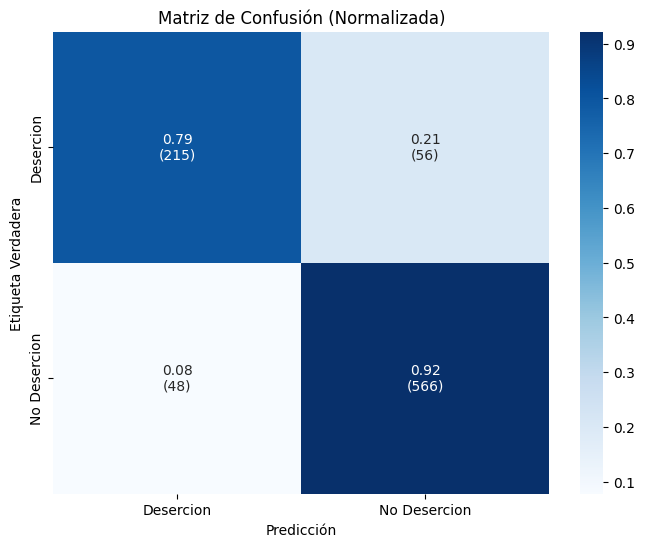

In [16]:
reporte_final_completo(results)